Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 48, 512)             │         536,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 48, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,361,412 (5.19 MB)

 Trainable params: 1,359,620 (5.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - loss: 0.9419 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 2/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.1757 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 3/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.1253 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 4/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0945 - val_loss: 0.0711 - learning_rate: 0.0010
Epoch 5/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0671 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 6/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0462 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 7/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0305 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 8/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0198 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 9/30
656/656 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0131 - val_loss: 0.0077 - learning_rate:

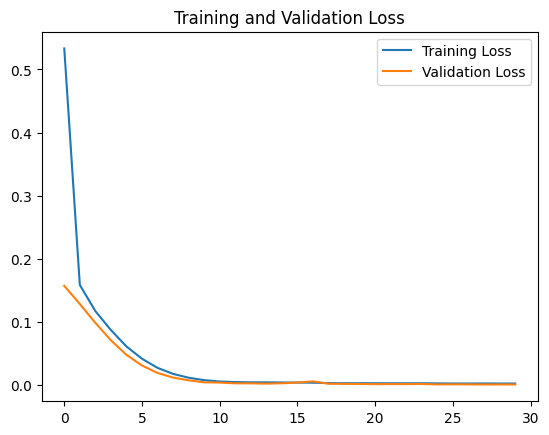

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

file_path = "/kaggle/input/weather-datased/weather.csv"
df = pd.read_csv(file_path)

df["time"] = pd.to_datetime(df["time"])  
df.sort_values(by="time", inplace=True)  
timestamps = df["time"]  
df.drop(columns=["time"], inplace=True)  

features = ["temperature_2m (°C)", "rain (mm)", "relative_humidity_2m (%)", "wind_speed_10m (km/h)", "wind_direction_100m (°)"]
df = df[features]

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)  

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

train_size = int(len(df) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

def create_sequences(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:i+n_input])
        y.append(data[i+n_input, :4])  
    return np.array(X), np.array(y)

n_input = 48
X_train, y_train = create_sequences(train_data, n_input)
X_test, y_test = create_sequences(test_data, n_input)

# نموذج محسّن بدون الخطأ
model = Sequential([
    Input(shape=(n_input, len(features))),
    Bidirectional(LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.0001))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.0001))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.0001))),
    BatchNormalization(),
    Dropout(0.3),

    Dense(4)  # المخرجات
])

optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-6)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, callbacks=[early_stopping, reduce_lr])

y_pred = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack((y_test, np.zeros((y_test.shape[0], data_scaled.shape[1] - 4)))))[:, :4]
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], data_scaled.shape[1] - 4)))))[:, :4]

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [7]:
model.save("/kaggle/working/weather_model.h5")

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model("/kaggle/input/mooooooooo/weather_model.h5", custom_objects={'mse': MeanSquaredError()})


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


<ipython-input-11-b1e66c4b1fc1>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new[col].fillna(df_new[col].mean(), inplace=True)


the prediction this days :
     temperature_2m (°C)  rain (mm)  relative_humidity_2m (%)  \
0              10.858134  -0.002516                 71.805627   
1              10.424409  -0.003869                 72.986963   
2               9.994380  -0.003956                 76.342513   
3               9.787160  -0.004166                 77.670085   
4               9.635379  -0.004034                 79.205141   
..                   ...        ...                       ...   
115            12.922656   0.003977                 43.313236   
116            12.344258   0.002571                 45.605288   
117            11.616858   0.001835                 50.121165   
118            10.771531   0.001774                 55.849054   
119             9.883208   0.002010                 61.020317   

     wind_speed_10m (km/h)  
0                 4.120944  
1                 2.263843  
2                 2.094291  
3                 1.946729  
4                 2.084185  
..                

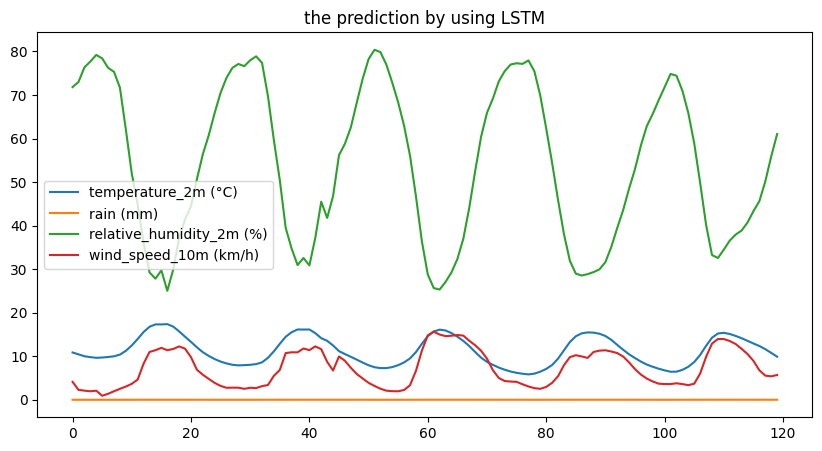

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

file_path = "/kaggle/input/currentdata/cairo_current_weather.csv"
df_new = pd.read_csv(file_path)

if "time" in df_new.columns:
    df_new["time"] = pd.to_datetime(df_new["time"])
    df_new.sort_values(by="time", inplace=True)
    df_new.drop(columns=["time"], inplace=True)

features = ["temperature_2m (°C)", "rain (mm)", "relative_humidity_2m (%)", "wind_speed_10m (km/h)", "wind_direction_100m (°)"]
df_new = df_new[features]

for col in df_new.columns:
    df_new[col].fillna(df_new[col].mean(), inplace=True)



scaler = MinMaxScaler()
scaler.fit(df_new)  3

data_scaled = scaler.transform(df_new)

n_input = 48  
X_test = []
for i in range(len(data_scaled) - n_input):
    X_test.append(data_scaled[i:i+n_input])
X_test = np.array(X_test)

if len(X_test) > 0:
    y_pred = model.predict(X_test)
    
    y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], data_scaled.shape[1] - 4)))))[:, :4]
    
    print("the prediction this days :")
    print(pd.DataFrame(y_pred_actual, columns=["temperature_2m (°C)", "rain (mm)", "relative_humidity_2m (%)", "wind_speed_10m (km/h)"]))
    
    plt.figure(figsize=(10, 5))
    for i, col in enumerate(["temperature_2m (°C)", "rain (mm)", "relative_humidity_2m (%)", "wind_speed_10m (km/h)"]):
        plt.plot(y_pred_actual[:, i], label=col)
    plt.legend()
    plt.title("the prediction by using LSTM")
    plt.show()
else:
    print("the data is not enough", n_input)


In [4]:
import joblib
features = ["temperature_2m (°C)", "rain (mm)", "relative_humidity_2m (%)", "wind_speed_10m (km/h)", "wind_direction_100m (°)"]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[features])
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']